In [1]:
import oceanspy as ospy
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [2]:
mooring_shelfExtended_kogur = xr.open_dataset(r'D:\MScData\mooring_shelfExtended_kogur.nc')
mooring_shelfExtended = xr.open_dataset(r'D:\MScData\mooring_shelfExtended.nc')
mooring_kogur = xr.open_dataset(r'D:\MScData\mooring_kogur.nc')
mooring_north = xr.open_dataset(r'D:\MScData\mooring_north.nc')
depth = xr.open_dataset(r'D:\MScData\Depth_res.nc')['Depth'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
depth_no_nan = depth
depth.to_netcdf('name.nc')

In [3]:
mooring_shelfExtended_kogur = ospy.OceanDataset(mooring_shelfExtended_kogur)
mooring_shelfExtended = ospy.OceanDataset(mooring_shelfExtended)
mooring_kogur = ospy.OceanDataset(mooring_kogur)
mooring_north = ospy.OceanDataset(mooring_north)

In [4]:
mooring_shelfExtended_kogur.dataset

<xarray.Dataset>
Dimensions:            (Z: 216, Zp1: 217, Zu: 216, Zl: 216, mooring: 43, Y: 1,
                        X: 1, Yp1: 2, Xp1: 2, time: 1460, time_midp: 1459,
                        mooring_midp: 42)
Coordinates: (12/29)
  * Z                  (Z) float64 -1.0 -3.5 -7.0 ... -3.922e+03 -3.942e+03
  * Zp1                (Zp1) float64 0.0 -2.0 -5.0 ... -3.932e+03 -3.951e+03
  * Zu                 (Zu) float64 -2.0 -5.0 -9.0 ... -3.932e+03 -3.951e+03
  * Zl                 (Zl) float64 0.0 -2.0 -5.0 ... -3.913e+03 -3.932e+03
    drF                (Z) float64 ...
    XC                 (mooring, Y, X) float64 ...
    ...                 ...
  * Y                  (Y) int64 0
  * Xp1                (Xp1) int64 0 1
  * Yp1                (Yp1) int64 0 1
    mooring_dist       (mooring) float64 ...
  * mooring_midp       (mooring_midp) float64 0.5 1.5 2.5 3.5 ... 39.5 40.5 41.5
    mooring_midp_dist  (mooring_midp) float64 ...
Data variables:
    U                  (time, Z, mooring, Y, Xp1) float64 ...
    V                  (time, Z, mooring, Yp1, X) float64 ...
    Temp               (time, Z, mooring, Y, X) float64 ...
    S                  (time, Z, mooring, Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

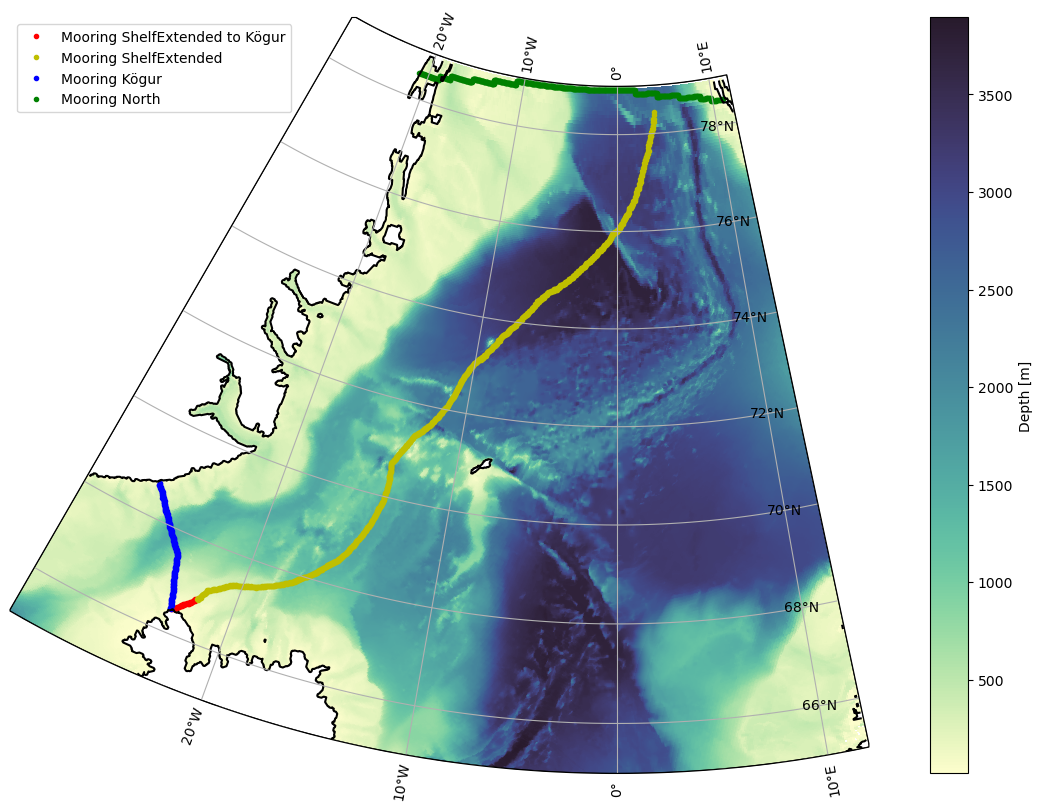

In [5]:
depth = depth.where(depth > 0, np.nan)

# Plot map and mooring locations
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained')

extent = [-30,12,65,79]

mesh = ax.pcolormesh(depth.X, depth.Y, depth, cmap=cmo.deep, transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh)
cbar.set_label('Depth [m]')

XC = [mooring_shelfExtended_kogur["XC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
YC = [mooring_shelfExtended_kogur["YC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
ax.plot(XC, YC, "r.", transform=ccrs.PlateCarree(), label='Mooring ShelfExtended to Kögur')

XC = [mooring_shelfExtended["XC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
YC = [mooring_shelfExtended["YC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
ax.plot(XC, YC, "y.", transform=ccrs.PlateCarree(), label='Mooring ShelfExtended')

XC = [mooring_kogur["XC"][x].values[0][0] for x in mooring_kogur['mooring']]
YC = [mooring_kogur["YC"][x].values[0][0] for x in mooring_kogur['mooring']]
ax.plot(XC, YC, "b.", transform=ccrs.PlateCarree(), label='Mooring Kögur')

XC = [mooring_north["XC"][x].values[0][0] for x in mooring_north['mooring']]
YC = [mooring_north["YC"][x].values[0][0] for x in mooring_north['mooring']]
ax.plot(XC, YC, "g.", transform=ccrs.PlateCarree(), label='Mooring North')

ax.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines and format them
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.legend(loc='upper left')

# Structure of Mooring array

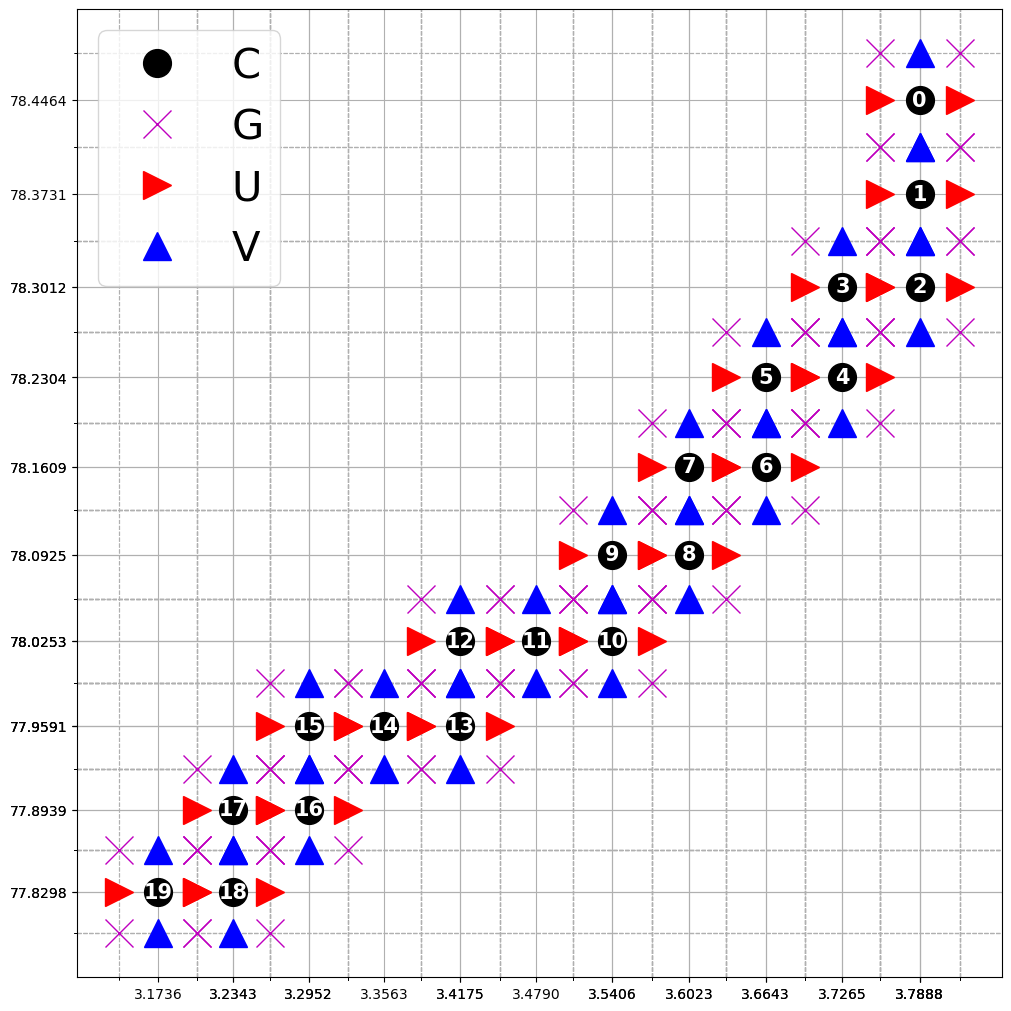

In [6]:
# Plot 10 moorings and their grid points
fig, ax = plt.subplots(1, 1, figsize=(10,10),layout='constrained')
n_moorings = 20

od_moor = mooring_shelfExtended
# Markers:
for _, (pos, mark, col) in enumerate(
    zip(["C", "G", "U", "V"], ["o", "x", ">", "^"], ["k", "m", "r", "b"])
):
    X = od_moor.dataset["X" + pos].values[:n_moorings].flatten()
    Y = od_moor.dataset["Y" + pos].values[:n_moorings].flatten()
    ax.plot(X, Y, col + mark, markersize=20, label=pos)
    if pos == "C":
        for i in range(n_moorings):
            ax.annotate(
                str(i),
                (X[i], Y[i]),
                size=15,
                weight="bold",
                color="w",
                ha="center",
                va="center",
            )
        ax.set_xticks(X, minor=False)
        ax.set_yticks(Y, minor=False)
    elif pos == "G":
        ax.set_xticks(X, minor=True)
        ax.set_yticks(Y, minor=True)
ax.legend(prop={"size": 30})
ax.grid(which="major", linestyle="-")
ax.grid(which="minor", linestyle="--")

In [7]:
# Show volume flux variables
ds_Vflux = ospy.compute.mooring_volume_transport(od_moor)
od_moor = od_moor.merge_into_oceandataset(ds_Vflux)

Computing horizontal volume transport.


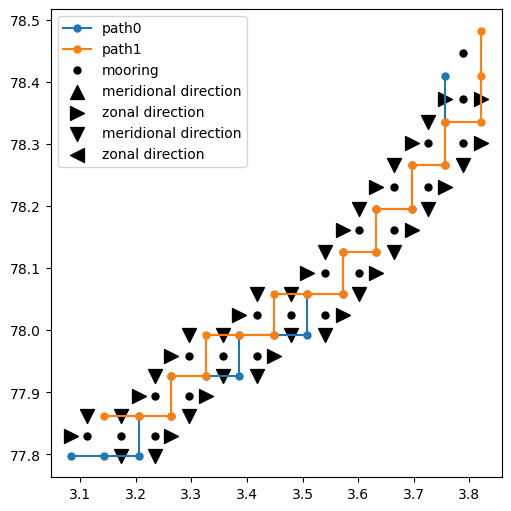

In [14]:
# Plot 10 moorings and volume flux directions.
fig, ax = plt.subplots(1, 1,figsize=(5,5),layout='constrained')
ms = 10
s = 100
ds = od_moor.dataset.sel(mooring=slice(0,20))
_ = ax.step(
    ds["XU"].isel(Xp1=0).squeeze().values,
    ds["YV"].isel(Yp1=0).squeeze().values,
    "C0.-",
    ms=ms,
    label="path0",
)
_ = ax.step(
    ds["XU"].isel(Xp1=1).squeeze().values,
    ds["YV"].isel(Yp1=1).squeeze().values,
    "C1.-",
    ms=ms,
    label="path1",
)
_ = ax.plot(ds["XC"].squeeze(), ds["YC"].squeeze(), "k.", ms=ms, label="mooring")
_ = ax.scatter(
    ds["X_Vtransport"].where(ds["dir_Vtransport"] == 1),
    ds["Y_Vtransport"].where(ds["dir_Vtransport"] == 1),
    s=s,
    c="k",
    marker="^",
    label="meridional direction",
)
_ = ax.scatter(
    ds["X_Utransport"].where(ds["dir_Utransport"] == 1),
    ds["Y_Utransport"].where(ds["dir_Utransport"] == 1),
    s=s,
    c="k",
    marker=">",
    label="zonal direction",
)
_ = ax.scatter(
    ds["X_Vtransport"].where(ds["dir_Vtransport"] == -1),
    ds["Y_Vtransport"].where(ds["dir_Vtransport"] == -1),
    s=s,
    c="k",
    marker="v",
    label="meridional direction",
)
_ = ax.scatter(
    ds["X_Utransport"].where(ds["dir_Utransport"] == -1),
    ds["Y_Utransport"].where(ds["dir_Utransport"] == -1),
    s=s,
    c="k",
    marker="<",
    label="zonal direction",
)
# Only show a few moorings
m_start = 50
m_end = 70
xlim = ax.set_xlim(
    sorted(
        [
            ds["XC"].isel(mooring=m_start).values,
            ds["XC"].isel(mooring=m_end).values,
        ]
    )
)
ylim = ax.set_ylim(
    sorted(
        [
            ds["YC"].isel(mooring=m_start).values,
            ds["YC"].isel(mooring=m_end).values,
        ]
    )
)
ax.legend()

# Vertical Sections

Computing potential density anomaly using the following parameters: {'eq_state': 'mdjwf'}.
Computing weighted_mean.
Regridding [w_mean_V] along [Y]-axis.
Computing weighted_mean.


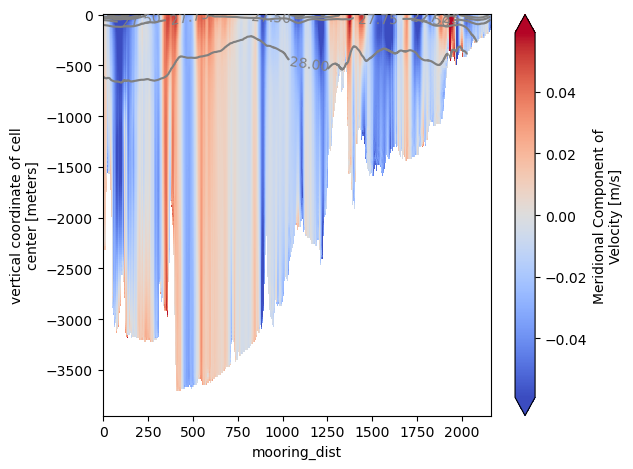

In [15]:
# Plot time mean
ax = od_moor.plot.vertical_section(
    varName="V",
    contourName="Sigma0",
    meanAxes="time",
    robust=True,
    cmap="coolwarm",
)